# Diagnostics, analysis and visualization tools <br /> for Integrated Assessment timeseries data

<img style="float: right; height: 100px; margin-top: 10px;" src="_static/IIASA_logo.png">
<img style="float: right; height: 80px;" src="_static/IAMC_logo.jpg">

## First steps with the ``pyam`` package

The ``pyam-analysis`` package provides a range of diagnostic tools and functions  
for analyzing and working with IAMC-style timeseries data. 

The package can be used with data that follows the data template convention 
of the [Integrated Assessment Modeling Consortium](http://www.globalchange.umd.edu/iamc/) (IAMC).
An illustrative example is shown below;
see [data.ene.iiasa.ac.at/database](http://data.ene.iiasa.ac.at/database/) for more information.


| **Model**           | **Scenario**  | **Region** | **Variable**   | **Unit** | **2005** | **2010** | **2015** |
|---------------------|---------------|------------|----------------|----------|----------|----------|----------|
| MESSAGE V.4         | AMPERE3-Base  | World      | Primary Energy | EJ/y     | 454.5    |	479.6    | ...      |
| ...                 | ...           | ...        | ...            | ...      | ...      | ...      | ...      |

This notebook illustrates some basic functionality of the ``pyam-analsysis`` package
and the ``IamDataFrame`` class:

0. Importing timeseries data from a csv file.
0. Listing models, scenarios and variables included in the data.
0. Display of timeseries data as dataframe and visualization using simple plotting functions.
0. Evaluating the model data and executing a range of diagnostic checks to identify data outliers.
0. Categorization of scenarios according to timeseries data.
0. Exporting data to Excel


## Tutorial data

The timeseries data used in this tutorial is a partial snapshot of the scenario database 
compiled for the IPCC's Fifth Assessment Report (AR5):

> Krey V., O. Masera, G. Blanford, T. Bruckner, R. Cooke, K. Fisher-Vanden, H. Haberl, E. Hertwich, E. Kriegler, D. Mueller, S. Paltsev, L. Price, S. Schlömer, D. Ürge-Vorsatz, D. van Vuuren, and T. Zwickel, 2014: *Annex II: Metrics & Methodology*.   
> In: *Climate Change 2014: Mitigation of Climate Change. Contribution of Working Group III to the Fifth Assessment Report of the Intergovernmental Panel on Climate Change* [Edenhofer, O., R. Pichs-Madruga, Y. Sokona, E. Farahani, S. Kadner, K. Seyboth, A. Adler, I. Baum, S. Brunner, P. Eickemeier, B. Kriemann, J. Savolainen, S. Schlömer, C. von Stechow, T. Zwickel and J.C. Minx (eds.)]. Cambridge University Press, Cambridge, United Kingdom and New York, NY, USA. [Link](https://www.ipcc.ch/report/ar5/wg3/)

The complete database is publicly available at [tntcat.iiasa.ac.at/AR5DB/](https://tntcat.iiasa.ac.at/AR5DB/).

<img style="float: right; height: 100px;" src="_static/AMPERE-Logo.png">
<img style="float: right; height: 40px; margin-top: 50px; margin-right: 20px;" src="_static/EMF-Logo_v2.1.png">

The data snapshot used for this tutorial consists of selected data from two model intercomparison projects:
 - Energy Modeling Forum Round 27 
   ([**EMF27**](https://emf.stanford.edu/projects/emf-27-global-model-comparison-exercise)),
   see the Special Issue in [*Climatic Change* 3-4, 2014](https://link.springer.com/journal/10584/123/3/page/1).
 - EU FP7 project [**AMPERE**](https://tntcat.iiasa.ac.at/AMPEREDB/), 
   see the following scientific publications:
   > - Riahi, K., et al. (2015). "Locked into Copenhagen pledges — Implications of short-term emission targets 
   >   for the cost and feasibility of long-term climate goals." 
   >   *Technological Forecasting and Social Change* 90(Part A): 8-23.  
   >   [DOI: 10.1016/j.techfore.2013.09.016](https://doi.org/10.1016/j.techfore.2013.09.016)
   > - Kriegler, E., et al. (2015). "Making or breaking climate targets: The AMPERE study on 
   >   staged accession scenarios for climate policy."
   >   *Technological Forecasting and Social Change* 90(Part A): 24-44.  
   >   [DOI: 10.1016/j.techfore.2013.09.021](https://doi.org/10.1016/j.techfore.2013.09.021)

<div style="text-align: center; padding: 10px; border: 2px solid red; width: 700px">
*The data used in this tutorial is ONLY a partial snapshot of the IPCC AR5 scenario database!*  
*This tutorial is only intended for an illustration of the ``pyam-analysis`` package.*
</div>

## Import package and load data from the AR5 tutorial csv snapshot file

First, we import the snapshot timeseries data from the file ``tutorial_AR5_data.csv`` in the ``tutorial`` folder.

As a first step, we show lists of all models, scenarios, regions, and variables (with units) included in the snapshot.

In [1]:
import pyam as iam
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
df = iam.IamDataFrame(data='tutorial_AR5_data.csv', encoding='utf-8')

In [3]:
df['model'].unique()

array([u'AIM-Enduse 12.1', u'GCAM 3.0', u'IMAGE 2.4', u'MERGE_EMF27',
       u'MESSAGE V.4', u'REMIND 1.5', u'WITCH_EMF27'], dtype=object)

In [4]:
df[['model', 'scenario']].head()

,model,scenario
0,AIM-Enduse 12.1,EMF27-450-Conv
1,AIM-Enduse 12.1,EMF27-450-Conv
2,AIM-Enduse 12.1,EMF27-450-Conv
3,AIM-Enduse 12.1,EMF27-450-Conv
4,AIM-Enduse 12.1,EMF27-450-Conv


In [5]:
df[['variable', 'unit']].head()

,variable,unit
0,Emissions|CO2,Mt CO2/yr
1,Emissions|CO2|Fossil Fuels and Industry,Mt CO2/yr
2,Primary Energy,EJ/yr
3,Emissions|CO2,Mt CO2/yr
4,Emissions|CO2|Fossil Fuels and Industry,Mt CO2/yr


## Tutorial on data filtering
Most functions of the ``IamDataFrame`` class take an (optional) argument ``filters``,
i.e., a dictionary of filter criteria.

### Filtering by model names, scenarios and regions

The feature for filtering by **model, scenario or region** is implemented
using [regular expressions](https://docs.python.org/3.6/library/re.html) (regex, re)
and the _re.match()_ function.
This implies that the filtering is done from the beginning of the text string.
> Applying the filter ``'model': 'MESSAGE'`` to the function ``scenarios()`` 
  will return all MESSAGE V.4 scenarios included in the snapshot.  
> Filtering for _ESSAGE_ will return an empty set.

In [6]:
df.filter({'model': 'MESSAGE'})['scenario'].unique()

array([u'AMPERE3-450', u'AMPERE3-450P-EU', u'AMPERE3-550',
       u'AMPERE3-RefPol', u'EMF27-550-LimBio', u'EMF27-Base-FullTech'], dtype=object)

In [7]:
df.filter({'model': 'ESSAGE'})['scenario'].unique()

array([], dtype=object)

### Filtering by variables and hierarchy levels

Filtering for **variable** strings using regex
is problematic due to the frequent use of the ``"|"`` character in the IAMC template
to specify a hierarchical.
Therefore, this package implements a pseudo-regex syntax, 
where ``|`` is escaped, ``*`` is used as a wildcard
and exact matching at the end of the string is enforced.
(in regex lingo, ``*`` is replaced by ``.*`` and ``$`` is appended to the filter string).
> Filtering for _Primary Energy_ will return only exactly those data.  
> Filtering for _Primary Energy|*_ will return all sub-categories of 
> primary-energy level (and only the sub-categories).

In additon, IAM variables can be filtered by the **level**,
i.e., the "depth" of the variable in a hierarchical reading of the string separated by `"|"`.
That is, the variable _Primary Energy_ has level 0, while _Primary Energy|Coal_ has level 1.
Filtering by both **variables** and **level** will search for the hierarchical depth 
_following the <variable> string_, so filter arguments _Primary Energy|*_ and _level = 0_
will return all variables immediately below _Primary Energy_.
Filtering by **level** only will return all variables up to that depth.

To illustrate the functionality of the filters, we first show all sub-categories of the ``Emissions`` variable.  
Then, we reduce variables to only two hierarchical levels below ``"Emissions|"``; the list returned by the function call will not include ``Emissions|CO2|Fossil Fuels and Industry|Energy Supply|Electricity``, because this variable is three hierarchical levels below ``"Emissions|"``.

The third example shows how to filter only by hierarchical level. The function returns all variables that are at the top hierarchical level (i.e., ``Primary Energy``) and those at the first sub-category level.
Keep in mind that there are no variables ``Emissions`` or ``Price`` (no top level).

In [8]:
df.filter(filters={'variable': 'Emissions|*'})['variable'].unique()

array([u'Emissions|CO2', u'Emissions|CO2|Fossil Fuels and Industry',
       u'Emissions|CO2|Fossil Fuels and Industry|Energy Supply',
       u'Emissions|CO2|Fossil Fuels and Industry|Energy Supply|Electricity'], dtype=object)

In [9]:
df.filter(filters={'variable': 'Emissions|*', 'level': 2})['variable'].unique()

array([u'Emissions|CO2|Fossil Fuels and Industry|Energy Supply'], dtype=object)

In [10]:
df.filter(filters={'level': '1-'})['variable'].unique()

array([u'Emissions|CO2', u'Primary Energy', u'Price|Carbon',
       u'Primary Energy|Coal'], dtype=object)

### Filtering by year

Filtering for **years** can be done by integer number, a list of integers, or the Python class ``range``.  
Note that the last year of a range is not included, so ``range(2010,2015)``
is interpreted as ``[2010, 2011, 2012, 2013, 2014]``.

## Getting help

When in doubt, you can look at the help for any function by appending it with a ``?``.

In [11]:
df.filter?

## Displaying timeseries data and plotting figures

As a next step, we want to view a selection of the data in the tutorial snapshot using the IAMC standard.
The filtered data can exported as a csv file by appending `.to_csv('selected_data.csv')` to the next command.

For displaying data in a different format, the class ``IamDataFrame`` has a wrapper of the ``pandas.DataFrame.pivot_table()`` function. It allows to flexibly specify the columns and rows.
The function automatically aggregates by summation or counting (specified by the parameter `aggfunc`) 
over all timeseries data identifiers ('model', 'scenario', 'variable', 'region', 'unit', 'year')
which are not used as `index` or `columns`.

In the example below, the filter of the timeseries data is set for all subcategories of 'Primary Energy', 
which are then summed up in the displayed table.

In [12]:
(df
 .filter(filters={'scenario': 'AMPERE3-450', 'variable': 'Primary Energy|Coal', 'region': 'World'})
 .timeseries()
)

year                                                            2005    2010  \
model       scenario        region variable            unit                    
GCAM 3.0    AMPERE3-450     World  Primary Energy|Coal EJ/yr  120.76  144.95   
            AMPERE3-450P-CE World  Primary Energy|Coal EJ/yr  120.76  144.95   
            AMPERE3-450P-EU World  Primary Energy|Coal EJ/yr  120.76  144.95   
IMAGE 2.4   AMPERE3-450     World  Primary Energy|Coal EJ/yr  111.62  138.69   
            AMPERE3-450P-CE World  Primary Energy|Coal EJ/yr  111.62  138.69   
            AMPERE3-450P-EU World  Primary Energy|Coal EJ/yr  111.62  138.69   
MESSAGE V.4 AMPERE3-450     World  Primary Energy|Coal EJ/yr  121.12  138.09   
            AMPERE3-450P-EU World  Primary Energy|Coal EJ/yr  121.12  138.09   
REMIND 1.5  AMPERE3-450     World  Primary Energy|Coal EJ/yr  122.20  135.47   
            AMPERE3-450P-CE World  Primary Energy|Coal EJ/yr  122.20  135.40   
            AMPERE3-450P-EU World  Primary Energy|Coal EJ/yr  122.20  135.39   

year                                                            2020    2030  \
model       scenario        region variable            unit                    
GCAM 3.0    AMPERE3-450     World  Primary Energy|Coal EJ/yr  176.44  204.42   
            AMPERE3-450P-CE World  Primary Energy|Coal EJ/yr  178.98  218.24   
            AMPERE3-450P-EU World  Primary Energy|Coal EJ/yr  189.86  241.25   
IMAGE 2.4   AMPERE3-450     World  Primary Energy|Coal EJ/yr  148.60  121.24   
            AMPERE3-450P-CE World  Primary Energy|Coal EJ/yr  161.72  154.18   
            AMPERE3-450P-EU World  Primary Energy|Coal EJ/yr  173.83  193.98   
MESSAGE V.4 AMPERE3-450     World  Primary Energy|Coal EJ/yr  119.94   93.11   
            AMPERE3-450P-EU World  Primary Energy|Coal EJ/yr  149.20  165.47   
REMIND 1.5  AMPERE3-450     World  Primary Energy|Coal EJ/yr   92.72   45.87   
            AMPERE3-450P-CE World  Primary Energy|Coal EJ/yr  120.77  124.53   
            AMPERE3-450P-EU World  Primary Energy|Coal EJ/yr  147.40  179.17   

year                                                            2040    2050  \
model       scenario        region variable            unit                    
GCAM 3.0    AMPERE3-450     World  Primary Energy|Coal EJ/yr  212.84  186.02   
            AMPERE3-450P-CE World  Primary Energy|Coal EJ/yr  213.35  192.45   
            AMPERE3-450P-EU World  Primary Energy|Coal EJ/yr  224.25  191.70   
IMAGE 2.4   AMPERE3-450     World  Primary Energy|Coal EJ/yr  102.62  101.41   
            AMPERE3-450P-CE World  Primary Energy|Coal EJ/yr  125.14  105.32   
            AMPERE3-450P-EU World  Primary Energy|Coal EJ/yr  153.90  122.29   
MESSAGE V.4 AMPERE3-450     World  Primary Energy|Coal EJ/yr   52.07   71.91   
            AMPERE3-450P-EU World  Primary Energy|Coal EJ/yr   95.13   64.39   
REMIND 1.5  AMPERE3-450     World  Primary Energy|Coal EJ/yr   22.33   20.39   
            AMPERE3-450P-CE World  Primary Energy|Coal EJ/yr   70.15   27.36   
            AMPERE3-450P-EU World  Primary Energy|Coal EJ/yr  103.90   33.31   

year                                                            2060    2070  \
model       scenario        region variable            unit                    
GCAM 3.0    AMPERE3-450     World  Primary Energy|Coal EJ/yr  138.23  106.98   
            AMPERE3-450P-CE World  Primary Energy|Coal EJ/yr  142.64  108.72   
            AMPERE3-450P-EU World  Primary Energy|Coal EJ/yr  136.72  102.51   
IMAGE 2.4   AMPERE3-450     World  Primary Energy|Coal EJ/yr  111.41  138.40   
            AMPERE3-450P-CE World  Primary Energy|Coal EJ/yr  120.83  151.58   
            AMPERE3-450P-EU World  Primary Energy|Coal EJ/yr  131.70  153.42   
MESSAGE V.4 AMPERE3-450     World  Primary Energy|Coal EJ/yr   98.09  127.76   
            AMPERE3-450P-EU World  Primary Energy|Coal EJ/yr   81.91  108.47   
REMIND 1.5  AMPERE3-450     World  Primary Energy|Coal EJ/yr   16.64   12.35 

In [13]:
(df
 .filter({'variable': 'Primary Energy', 'region': 'World'})
 .pivot_table(index=['year'], columns=['scenario'], values='value', aggfunc='sum')
)

scenario,AMPERE3-450,AMPERE3-450P-CE,AMPERE3-450P-EU,AMPERE3-550,AMPERE3-550P-EU,AMPERE3-Base-EUback,AMPERE3-CF450P-EU,AMPERE3-RefPol,EMF27-450-Conv,EMF27-450-NoCCS,EMF27-550-LimBio,EMF27-Base-FullTech,EMF27-G8-EERE
year,,,,,,,,,,,,,
2005,1821.09,1366.48,1821.09,1818.71,464.82,922.58,925.23,1818.44,2234.35,1381.84,3130.81,3130.60,868.79
2010,1972.13,1492.28,1972.02,1969.57,514.07,1015.78,1018.44,1969.50,2504.99,1542.90,3457.08,3459.28,985.16
2020,2253.49,1787.40,2399.41,2322.23,611.34,1258.24,1262.07,2401.37,2428.61,1424.26,3781.16,4135.65,947.08
2030,2530.95,2101.60,2863.85,2670.22,734.11,1532.12,1536.54,2869.96,2545.94,1470.64,4057.28,4846.37,933.08
2040,2795.47,2206.09,2940.96,3000.37,789.70,1802.62,1574.14,3305.70,2698.99,1670.51,4355.16,5588.19,1007.83
2050,3064.07,2348.02,3087.59,3312.70,815.79,2104.63,1652.02,3709.45,2759.41,1794.47,4586.40,6353.16,1075.16
2060,3321.63,2537.42,3317.84,3532.21,861.79,2359.38,1774.56,4056.44,2198.22,1257.99,4164.92,6172.01,531.36
2070,3512.57,2683.30,3526.56,3722.65,901.57,2564.68,1912.48,4391.18,2240.64,1344.42,4430.28,6768.95,563.62
2080,3689.77,2824.81,3724.06,3926.94,943.47,2708.68,2033.99,4700.20,2256.69,1461.97,4690.79,7288.74,568.90


If you are familiar with the `python` package `pandas`, you can treat the IamDataFrame similarly.

In [14]:
df.head()

,model,scenario,region,variable,unit,year,value
0,AIM-Enduse 12.1,EMF27-450-Conv,ASIA,Emissions|CO2,Mt CO2/yr,2005,10540.74
1,AIM-Enduse 12.1,EMF27-450-Conv,ASIA,Emissions|CO2|Fossil Fuels and Industry,Mt CO2/yr,2005,9126.18
2,AIM-Enduse 12.1,EMF27-450-Conv,ASIA,Primary Energy,EJ/yr,2005,133.56
3,AIM-Enduse 12.1,EMF27-450-Conv,LAM,Emissions|CO2,Mt CO2/yr,2005,3285.00
4,AIM-Enduse 12.1,EMF27-450-Conv,LAM,Emissions|CO2|Fossil Fuels and Industry,Mt CO2/yr,2005,1422.06


## Visualization of timeseries

Please see the `plotting.ipynb` notebook for a full tutorial on plotting.

## Validation and diagnostic assessment of timeseries data

When analyzing scenario results, it is often useful to check whether certain timeseries exist or the values are within a specific range. For example, it may make sense to ensure that reported data for historical periods are close to established reference data.

The following section provides three illustrations:
1. Check whether a timeseries `'Primary Energy'` exists in each scenario (in at least one year).
2. Check for every scenario whether the value for `'Primary Energy'` at the global level exceeds 515 EJ/y 
   in the reference year 2010
   (the value must satisfy an upper bound of 515 EJ/y in this notation).
3. Check for every scenario whether the value for `'Primary Energy|Coal'` exceeds 400 EJ/y in mid-century.

The `validate()` function takes a `filters` dictionary to perform the checks on a selection of models/scenarios
similar to the functions introduced above.  
The ``criteria`` argument can specify a valid range by an upper and lower bound (``up``, ``lo``) for a variable and a subset of years to which the validation is applied - all scenarios with a value in at least one year outside that range are considered to *not satisfy* the validation.

By setting the argument ``exclude=True``, all scenarios failing the validation will be categorized as ``exclude``.
These scenarios will not be shown by default in any subsequent data tables or plots.

In [15]:
df.validate?

In [16]:
df.validate(criteria={'Primary Energy': {'up': 515, 'year': 2010}})

INFO:root:9 of 6622 data points to not satisfy the criteria


,model,scenario,region,variable,unit,year,value
770,AIM-Enduse 12.1,EMF27-G8-EERE,World,Primary Energy,EJ/yr,2010,518.64
678,AIM-Enduse 12.1,EMF27-450-Conv,World,Primary Energy,EJ/yr,2010,518.89
1223,REMIND 1.5,EMF27-550-LimBio,World,Primary Energy,EJ/yr,2010,519.64
747,AIM-Enduse 12.1,EMF27-Base-FullTech,World,Primary Energy,EJ/yr,2010,518.81
1181,REMIND 1.5,EMF27-450-Conv,World,Primary Energy,EJ/yr,2010,519.64
1202,REMIND 1.5,EMF27-450-NoCCS,World,Primary Energy,EJ/yr,2010,519.64
724,AIM-Enduse 12.1,EMF27-550-LimBio,World,Primary Energy,EJ/yr,2010,518.81
1244,REMIND 1.5,EMF27-Base-FullTech,World,Primary Energy,EJ/yr,2010,519.64
701,AIM-Enduse 12.1,EMF27-450-NoCCS,World,Primary Energy,EJ/yr,2010,518.81


In [17]:
(df
 .filter(filters={'region': 'World'})
 .validate(criteria={'Primary Energy|Coal': {'up': 400, 'year': 2050}})
)

INFO:root:2 of 3565 data points to not satisfy the criteria


,model,scenario,region,variable,unit,year,value
3432,GCAM 3.0,AMPERE3-Base-EUback,World,Primary Energy|Coal,EJ/yr,2050,424.09
3659,MERGE_EMF27,EMF27-Base-FullTech,World,Primary Energy|Coal,EJ/yr,2050,605.76


In [18]:
iam.validate(df, 
             filters={'region': 'World'}, 
             criteria={'Primary Energy|Coal': {'up': 400, 'year': 2050}}
)

INFO:root:2 of 3565 data points to not satisfy the criteria


,model,scenario,region,variable,unit,year,value
3432,GCAM 3.0,AMPERE3-Base-EUback,World,Primary Energy|Coal,EJ/yr,2050,424.09
3659,MERGE_EMF27,EMF27-Base-FullTech,World,Primary Energy|Coal,EJ/yr,2050,605.76


## Categorization of scenarios by timeseries characteristics

It is often useful to apply categorization to classes of scenarios according to specific characteristics of the timeseries data.

In the following example, we use the temperature change assessment by MAGICC 6 to group scenarios by the median global warming by the end of the century (year 2100).

We proceed in the following steps:

0. Plot the timeseries data of the variable that we want to use. 
   This provides some insights on useful thresholds for the categorization.
0. Use the function ``category()`` to apply a categorization (and colour code for later use) 
   to all scenarios that satisfy a number of specific criteria.
0. Use the categorization of scenarios for analysis of other timeseries data.

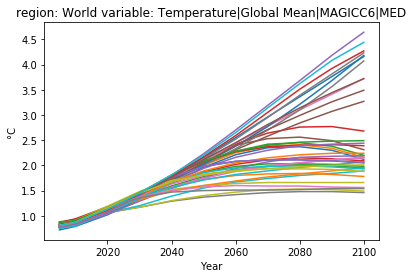

In [19]:
df.filter({'variable': 'Temperature*'}).line_plot()

We now use the categorization feature of the ``pyam-analysis`` package. 
By default, each model/scenario is assigned as ``"uncategorized"``.

The next function resets all scenarios back to ``"uncategorized"``. This may be helpful in this tutorial if you are going back and forth between cells.

In [20]:
df.categorize(
    'Temperature', 'Below 1.6C',
    criteria={'Temperature|Global Mean|MAGICC6|MED': {'up': 1.6, 'year': 2100}},
    color='cornflowerblue'
)

INFO:root:4 scenario(s) categorized as Temperature 'Below 1.6C'


In [21]:
df.categorize(
    'Temperature', 'Below 2.0C',
    criteria={'Temperature|Global Mean|MAGICC6|MED': {'up': 2.0, 'lo': 1.6, 'year': 2100}},
    color='forestgreen'
)

INFO:root:8 scenario(s) categorized as Temperature 'Below 2.0C'


In [22]:
df.categorize(
    'Temperature', 'Below 2.5C',
    criteria={'Temperature|Global Mean|MAGICC6|MED': {'up': 2.5, 'lo': 2.0, 'year': 2100}},
    color='gold'
)

INFO:root:16 scenario(s) categorized as Temperature 'Below 2.5C'


In [23]:
df.categorize(
    'Temperature', 'Below 3.5C',
     criteria={'Temperature|Global Mean|MAGICC6|MED': {'up': 3.5, 'lo': 2.5, 'year': 2100}},
     color='firebrick'
)

INFO:root:3 scenario(s) categorized as Temperature 'Below 3.5C'


In [24]:
df.categorize(
    'Temperature', 'Above 3.5C',
    criteria={'Temperature|Global Mean|MAGICC6|MED': {'lo': 3.5, 'year': 2100}},
    color='magenta'
)

INFO:root:9 scenario(s) categorized as Temperature 'Above 3.5C'


In [25]:
df.categorize('Temperature', 'No Data', criteria='uncategorized', color='white')

INFO:root:8 of 48 scenarios are uncategorized.


Two models included in the snapshot have not been assessed by MAGICC6 regarding their long-term climate and warming impact. Therefore, the timeseries ``'Temperature|Global Mean|MAGICC6|MED'`` does not exist, and they have not been categorized.

Below, we display all scenarios that are uncategorized at this point.

In [26]:
df['Temperature'].head(n=10)

model            scenario           
AIM-Enduse 12.1  EMF27-450-Conv            No Data
                 EMF27-450-NoCCS           No Data
                 EMF27-550-LimBio          No Data
                 EMF27-Base-FullTech       No Data
                 EMF27-G8-EERE             No Data
GCAM 3.0         AMPERE3-450            Below 2.5C
                 AMPERE3-450P-CE        Below 2.5C
                 AMPERE3-450P-EU        Below 2.5C
                 AMPERE3-550            Below 3.5C
                 AMPERE3-Base-EUback    Above 3.5C
Name: Temperature, dtype: object

Now, we again display the median global temperature increase for all scenarios, but we use the colouring by category to illustrate the common charateristics across scenarios.

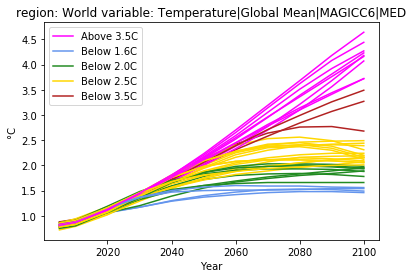

In [27]:
df.filter({'variable': 'Temperature*'}).line_plot(color='Temperature', legend=True)

As a last step, we display the aggregate CO2 emissions by category. This allows to highlight alternative pathways within the same category. 

In this step, we also export this figure as a png using the option ``save``. The figure will be saved in the tutorials folder.

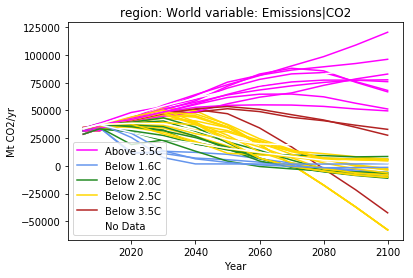

In [28]:
fig, ax = plt.subplots()
(df
 .filter({'variable': 'Emissions|CO2', 'region': 'World'})
 .line_plot(ax=ax, color='Temperature', legend=True)
)
fig.savefig('co2_emissions.png')

## Writing data to Excel

The IamDataFrame can be directly exported to Excel in the standard IAMC format.
This feature is based on [pandas.DataFrame.to_excel()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_excel.html) and can use any keyword arguments of that function.

In [29]:
df.to_excel('tutorial_export.xlsx')
df.export_metadata('tutorial_metadata.xlsx')